In [1]:
import pandas as pd
import numpy as np
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# from sklearn2pmml.preprocessing import ExpressionTransformer
# from sklearn_pandas import DataFrameMapper

In [19]:
# del log_scorer
# del to_logs
del standardize
%run '../code/constants.py'
%run '../code/feature_selection.py'
%run '../code/preprocessing.py'

In [3]:
#not binned
# cols = list(set(list(pd.read_pickle(path + mod_fs)['column']) + ['y'] + model_extra_vars))
# df = pd.read_pickle(path + mod_fname)[cols]

#binned
df = pd.read_pickle(path + fin_mod_df)

In [4]:
for i in range(0, len(trend_vars), 2):
    name = 'trend_' + trend_vars[i].split('.')[-1]
    df[name] = df[trend_vars[i]] - df[trend_vars[i+1]]
df = df.drop(trend_vars, axis=1)

In [5]:
df.columns

Index(['clear-bank-behavior.cbb-reason-codes.BB113',
       'request.merchant.subgroup_corporate',
       'fis-chex-advisor.debit-bureau-reason-codes.EB',
       'clear-bank-behavior.cbb-reason-codes2.BB211',
       'pmml_variables.fe_related_location_blacklisted',
       'third_party.clarity_cbb.backend_extra_variables.is_cache_response',
       'pmml_variables.fe_user_location_state_mismatch',
       'pmml_variables.fe_merchant_id_92',
       'third_party.clarity_cbb.clear-bank-behavior.cbb-score',
       'clear-bank-behavior.cbb-reason-codes2.BB201',
       'clear-bank-behavior.cbb-reason-codes2.BB209',
       'third_party.clarity_cbb.clear-bank-behavior.positive-check-writing-history',
       'clear-bank-behavior.cbb-reason-codes.BB105',
       'fis-chex-advisor.debit-bureau-reason-codes.EH',
       'clear-bank-behavior.reason-codes.B09',
       'pmml_variables.cbb_address_state_tx', 'y',
       'clear-bank-behavior.cbb-reason-codes2.BB207',
       'third_party.clarity_cbb.clear-ba

make plots of variablesb

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import math

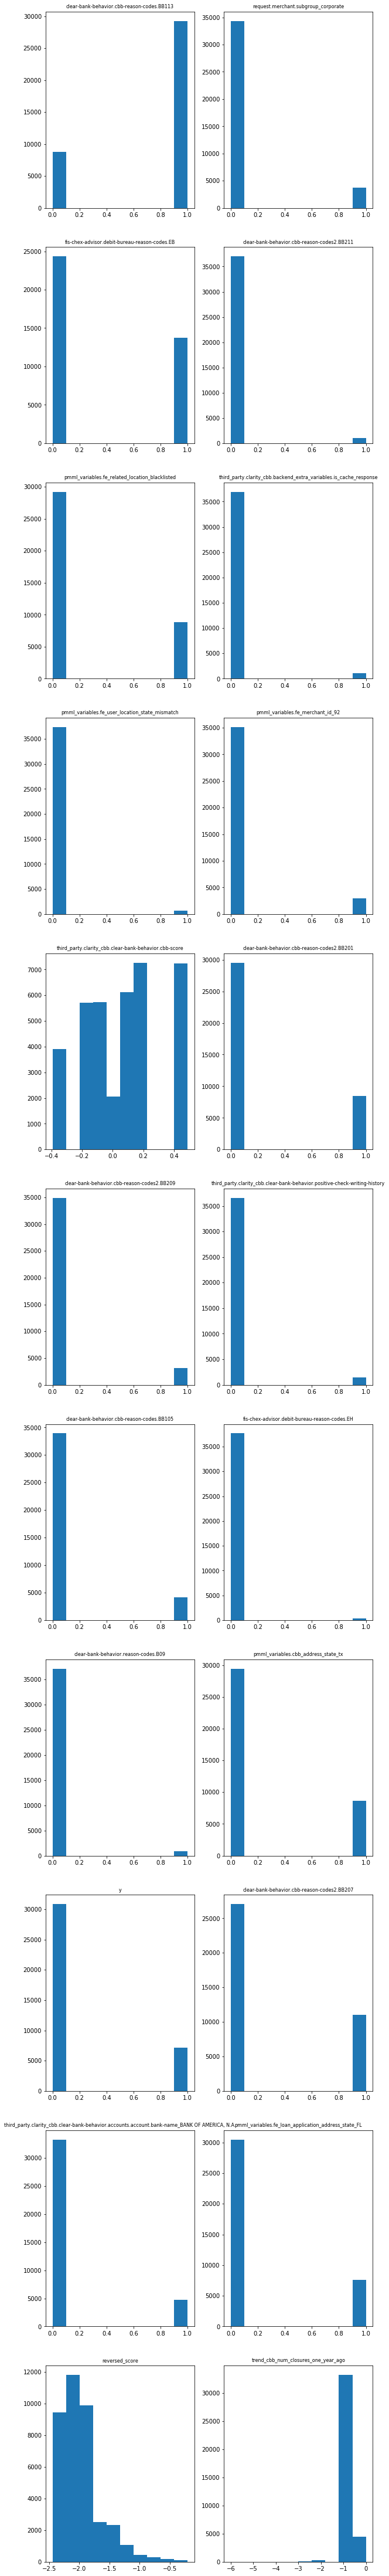

In [7]:
num_cols = 2
num_rows = math.ceil(len(df.columns)/num_cols)
fig, axs = plt.subplots(num_rows, num_cols, sharey=False, figsize=(10, 80))
for i, col in enumerate(df.columns):
    which_row = math.floor(i/num_cols)
    which_col = i % num_cols
#     print (which_row, which_col)
    axs[which_row][which_col].set_title(col, fontsize=8)
    axs[which_row][which_col].hist(df[col].fillna(-1).values)

In [ ]:
# tried logging didn't really improve score
# df[to_logs] = df[to_logs].apply(make_log)

In [ ]:
# df[c.to_logs].describe()

In [8]:
X, y = get_x_y(df)

In [9]:
pl = Pipeline([
    ('impute', SimpleImputer(strategy='median'))
    , ('standardize', StandardScaler())
#     , ('interactions', PolynomialFeatures(include_bias=False))
    , ('clf', SGDClassifier())
])

In [10]:
l1_ratio = [0.08, 0.1, 0.12]

alpha = [0.002, 0.004, 0.008]

alpha = [0.006, 0.01, 0.12]

alpha = [0.001, 0.002, 0.003, 0.004]

l1_ratio = [0.1, 0.12, 0.13]

# logistic regression
C_options = [0.01, 0.02, 0.04, 0.08]

C_options = [0.04, 0.08, 0.1]

C_options = [0.03, 0.04, 0.05]

C_options = [0.1, 0.2, 0.4, 0.8, 1]

gbm_loss = ['deviance', 'exponential']
gbm_lr = [0.01, 0.02, 0.03]
# min_samples_split = [2]


In [11]:
param_grid =  [
    {
    'standardize__with_std': [True, False]
    , 'clf': [SGDClassifier(penalty='elasticnet', max_iter=500, loss='log')]
    , 'clf__l1_ratio': l1_ratio
    , 'clf__alpha': alpha
  }, 
{
    'standardize__with_std': [True, False],
     'clf': [LogisticRegression(penalty='l2', max_iter=500)]
    , 'clf__C': C_options
  }
#      , {
#         'clf': [GradientBoostingClassifier()]
#         , 'clf__loss': gbm_loss
#         , 'clf__learning_rate': gbm_lr
#         , 'clf__min_samples_split': min_samples_split
# #         , 'clf__min_samples_leaf': min_samples_leaf
#     }
]
# , {
#     'clf': [LogisticRegression()]
#     , 'clf__C': C_options
# }

In [12]:
grid = GridSearchCV(pl, param_grid=param_grid, scoring={'auc': auc_scorer, 'log': log_scorer}
                    , refit='log', cv=6, verbose=5, return_train_score=True, n_jobs=2)

In [13]:
grid.fit(X.values, y)

Fitting 6 folds for each of 34 candidates, totalling 204 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   35.9s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done 204 out of 204 | elapsed:  5.9min finished
/Users/xiaowei/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('impute', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid=[{'standardize__with_std': [True, False], 'clf': [SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=500,
       n_iter=None, n_iter_no_ch...ver='warn',
          tol=0.0001, verbose=0, warm_start=False)], 'clf__C': [0.1, 0.2, 0.4, 0.8, 1]}],
       pre_dispatch='2*n_jobs', refit='l

In [14]:
cv_df = pd.DataFrame(grid.cv_results_)
cv_df

mean_fit_time  mean_score_time  mean_test_auc  mean_test_log  \
0        4.994847         0.011928       0.592780      -0.477181   
1        4.708173         0.009657       0.592283      -0.477204   
2        4.710178         0.010352       0.592644      -0.477199   
3        4.633986         0.009240       0.592222      -0.477213   
4        4.659075         0.010263       0.592658      -0.477199   
5        4.711242         0.009469       0.592189      -0.477216   
6        4.652850         0.009992       0.592647      -0.477185   
7        4.673929         0.009561       0.591541      -0.477308   
8        4.732760         0.010279       0.592639      -0.477185   
9        4.757934         0.010448       0.591353      -0.477337   
10       4.937141         0.010534       0.592638      -0.477187   
11       4.721211         0.009405       0.591223      -0.477357   
12       4.648853         0.010253       0.592594      -0.477187   
13       4.716719         0.009640       0.590690      -0.477461   
14       4.823528         0.010563       0.592548      -0.477190   
15       4.757431         0.009999       0.590326      -0.477517   
16       4.778690         0.010805       0.592537      -0.477190   
17       4.743845         0.009697       0.590056      -0.477560   
18       4.747222         0.010609       0.592524      -0.477189   
19       4.742003         0.009420       0.589723      -0.477645   
20       4.863483         0.010714       0.592474      -0.477194   
21       4.779148         0.009748       0.589069      -0.477743   
22       4.845629         0.010762       0.592459      -0.477196   
23       4.821624         0.009825       0.588958      -0.477763   
24       0.174411         0.010301       0.592773      -0.477191   
25       0.181201         0.009639       0.592720      -0.477171   
26       0.167621         0.010431       0.592771      -0.477193   
27       0.180336         0.009478       0.592753      -0.477181   
28       0.164140         0.009929       0.592771      -0.477194   
29       0.177120         0.009459       0.592756      -0.477187   
30       0.161973         0.009885       0.592772      -0.477195   
31       0.179716         0.009241       0.592764      -0.477191   
32       0.163226         0.010437       0.592772      -0.477195   
33       0.175773         0.009270       0.592764      -0.477192   

    mean_train_auc  mean_train_log  \
0         0.596380       -0.476172   
1         0.595995       -0.476253   
2         0.596372       -0.476172   
3         0.595964       -0.476262   
4         0.596370       -0.476172   
5         0.595943       -0.476266   
6         0.596346       -0.476175   
7         0.595364       -0.476422   
8         0.596348       -0.476176   
9         0.595253       -0.476448   
10        0.596343       -0.476177   
11        0.595180       -0.476463   
12        0.596323       -0.476182   
13        0.594600       -0.476625   
14        0.596312       -0.476185   
15        0.594359       -0.476675   
16        0.596312       -0.476187   
17        0.594213       -0.476705   
18        0.596291       -0.476192   
19        0.593777       -0.476840   
20        0.596272       -0.476197   
21        0.593341       -0.476923   
22        0.596263       -0.476201   
23        0.593200       -0.476956   
24        0.596391       -0.476170   
25        0.596326       -0.476177   
26        0.596392       -0.476169   
27        0.596362       -0.476171   
28        0.596393       -0.476169   
29        0.596380       -0.476170   
30        0.596393       -0.476169   
31        0.596387       -0.476169   
32        0.596393       -0.476169   
33        0.596388       -0.476169   

                                            param_clf param_clf__C  \
0   SGDClassifier(alpha=0.0001, average=False, cla...          NaN   
1   SGDClassifier(alpha=0.0001, average=False, cla...          NaN   
2   SGDClassifier(alpha=0.0001, average=False, cla...          NaN   
3   SGDClass

In [16]:
grid.best_params_

{'clf': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=500, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'clf__C': 0.1,
 'standardize__with_std': False}

In [17]:
# 0.6141658335093392 BINNED
grid.best_score_

-0.47717052908470431

Look over coefficients of best model and a quick QC

In [20]:
X_trans = X.pipe(impute_df, 'median').pipe(standardize, with_std=False)

/Users/xiaowei/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [21]:
# lr = GradientBoostingClassifier(learning_rate=0.03, min_samples_split=8)
lr = LogisticRegression(penalty='l2', max_iter=500, C=0.8)
# lr = SGDClassifier(penalty='elasticnet', max_iter=450, loss='log', alpha=0.004, l1_ratio=0.12)

In [22]:
themod, train_score, score = eval_model(lr, X_trans, y, roc_auc_score)

/Users/xiaowei/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [23]:
# 0.6240232226730864 0.5916657712922128
print(train_score, score)

0.59643337926 0.58531342436


In [24]:
themod.coef_[0]

array([ 0.13062312,  0.12041248,  0.19237411, -0.17236379,  0.09253883,
        0.15900508,  0.2539921 ,  0.16934733, -0.56844885, -0.09103838,
       -0.16314154, -0.13475947,  0.1668311 ,  0.35985403,  0.18046208,
       -0.15692503, -0.12272183,  0.07480507,  0.11407224,  0.44057052,
       -0.07177425])

In [25]:
X_col_df = X.dtypes.to_frame()
X_col_df.columns = ['data_type']
X_col_df['coef'] = themod.coef_[0]
X_col_df['data_type'] = X_col_df.data_type.apply(lambda v: str(v))
X_col_df.sort_values('coef')

data_type      coef
third_party.clarity_cbb.clear-bank-behavior.cbb...   float64 -0.568449
clear-bank-behavior.cbb-reason-codes2.BB211             int8 -0.172364
clear-bank-behavior.cbb-reason-codes2.BB209             int8 -0.163142
pmml_variables.cbb_address_state_tx                     int8 -0.156925
third_party.clarity_cbb.clear-bank-behavior.pos...      int8 -0.134759
clear-bank-behavior.cbb-reason-codes2.BB207             int8 -0.122722
clear-bank-behavior.cbb-reason-codes2.BB201             int8 -0.091038
trend_cbb_num_closures_one_year_ago                  float64 -0.071774
third_party.clarity_cbb.clear-bank-behavior.acc...     uint8  0.074805
pmml_variables.fe_related_location_blacklisted          int8  0.092539
pmml_variables.fe_loan_application_address_stat...     uint8  0.114072
request.merchant.subgroup_corporate                    uint8  0.120412
clear-bank-behavior.cbb-reason-codes.BB113              int8  0.130623
third_party.clarity_cbb.backend_extra_variables...      int8  0.159005
clear-bank-behavior.cbb-reason-codes.BB105              int8  0.166831
pmml_variables.fe_merchant_id_92                       uint8  0.169347
clear-bank-behavior.reason-codes.B09                    int8  0.180462
fis-chex-advisor.debit-bureau-reason-codes.EB           int8  0.192374
pmml_variables.fe_user_location_state_mismatch          int8  0.253992
fis-chex-advisor.debit-bureau-reason-codes.EH           int8  0.359854
reversed_score                                       float64  0.440571

In [26]:
X_col_df.to_csv('../outputs/model_dictionary.csv')

Done!